In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/hand_labels_synth.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:
!pip install timm


**IMPORT**

In [ ]:
import json
import os
import random
import time

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import mediapipe as mp





In [ ]:
data_folder = '/content/hand_labels_synth/'



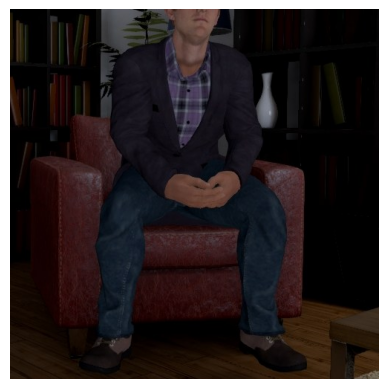

In [ ]:


# Укажите имя файла изображения (например, '0001.jpg')
image_filename = '0004.jpg'

# Формируем полный путь к файлу изображения
image_path = os.path.join(data_folder, 'synth1', image_filename)

# Открываем изображение
image = Image.open(image_path)

# Отображаем изображение
plt.imshow(image)
plt.axis('off')
plt.show()



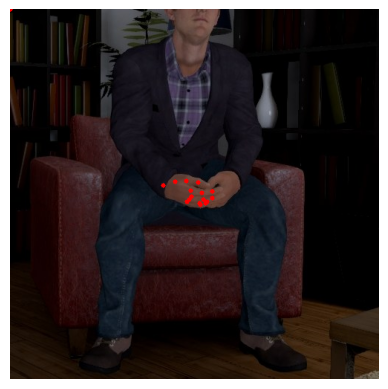

In [ ]:

image_filename = '0004.jpg'
keypoints_filename = '0004.json'
image_path = os.path.join(data_folder, 'synth1', image_filename)
keypoints_path = os.path.join(data_folder, 'synth1', keypoints_filename)


image = Image.open(image_path)
with open(keypoints_path, 'r') as keypoints_file:
    keypoints_data = json.load(keypoints_file)

# Преобразуем изображение PIL
image_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)


for keypoint in keypoints_data['hand_pts']:
    if keypoint != 0:
        cv2.circle(image_cv2, (int(keypoint[0]), int(keypoint[1])), 3, (0, 0, 255), -1)


plt.imshow(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



----

In [ ]:
 def extract_hand_data(data_directory):
    hand_data = []

    folders = sorted([folder for folder in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, folder)) and folder != 'output_viz_synth'])

    for folder in folders:
        image_files = [file for file in os.listdir(os.path.join(data_directory, folder)) if file.endswith('.jpg')]

        for image_file in image_files:
            annotation_file = image_file.replace('.jpg', '.json')
            annotation_path = os.path.join(data_directory, folder, annotation_file)

            if not os.path.exists(annotation_path):
                continue

            json_data = json.load(open(annotation_path))
            is_left_hand = json_data['is_left']
            hand_pts = json_data['hand_pts']

            empty_coords = [[0, 0] for _ in range(21)]

            if is_left_hand:
                keypoints = np.array(empty_coords + [coord[:2] for coord in hand_pts]).astype(int)
            else:
                keypoints = np.array([coord[:2] for coord in hand_pts] + empty_coords).astype(int)

            hand_data.append({'image_path': os.path.join(data_directory, folder, image_file), 'keypoints': keypoints})

    df = pd.DataFrame(hand_data)
    return df

hand_data_dir = '/content/hand_labels_synth'
hand_df = extract_hand_data(hand_data_dir)

print(hand_df.tail(5))



                                           image_path  \
14256  /content/hand_labels_synth/synth4/00001797.jpg   
14257  /content/hand_labels_synth/synth4/00001151.jpg   
14258  /content/hand_labels_synth/synth4/00001152.jpg   
14259  /content/hand_labels_synth/synth4/00000075.jpg   
14260  /content/hand_labels_synth/synth4/00000370.jpg   

                                               keypoints  
14256  [[424, 481], [447, 533], [466, 578], [502, 587...  
14257  [[541, 469], [536, 523], [524, 568], [502, 579...  
14258  [[654, 484], [601, 502], [568, 501], [523, 486...  
14259  [[473, 408], [522, 452], [542, 453], [508, 492...  
14260  [[527, 534], [535, 549], [542, 559], [546, 563...  


In [ ]:
print(hand_df.head(5))

                                   image_path  \
0  /content/hand_labels_synth/synth1/2557.jpg   
1  /content/hand_labels_synth/synth1/6237.jpg   
2  /content/hand_labels_synth/synth1/0639.jpg   
3  /content/hand_labels_synth/synth1/3560.jpg   
4  /content/hand_labels_synth/synth1/3921.jpg   

                                           keypoints  
0  [[215, 178], [217, 186], [219, 199], [219, 211...  
1  [[228, 245], [248, 244], [265, 238], [276, 236...  
2  [[151, 125], [151, 139], [159, 151], [161, 163...  
3  [[157, 139], [154, 128], [146, 127], [134, 129...  
4  [[295, 243], [307, 258], [316, 277], [319, 293...  


In [ ]:
class HandsDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.image_paths = self.data['image_path'].tolist()
        self.transform = transform if transform else self._default_transform()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.loc[idx, 'image_path']
        image = Image.open(image_name).convert('RGB')
        image = np.asarray(image)
        old_shape = image.shape[0]
        image = self.transform(image=image)['image']

        # пересчитываем координаты с учетом резайса картинки
        keypoints = self.data.loc[idx, 'keypoints'] / (old_shape / 224)  # Замените на имя столбца с координатами ключевых точек
        keypoints = torch.tensor([item for sublist in keypoints for item in sublist])

        return image.float(), keypoints.float(), image_name


In [ ]:
batch_size = 12
seed = 42
train_df, val_df = train_test_split(hand_df, test_size=0.3, random_state=seed)

train_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = HandsDataset(train_df.reset_index(drop=True), transform=train_transform)
val_dataset = HandsDataset(val_df.reset_index(drop=True), transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = timm.create_model('tf_efficientnetv2_s_in21k', pretrained=True).to(device)

additional_layers = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU()
)
model.classifier = nn.Sequential(
    nn.Linear(256, 84)
)

model.classifier = nn.Sequential(additional_layers, model.classifier)
model.to(device);



/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(


In [ ]:
loss_f = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
epochs = 10

In [ ]:
import time
start = time.time()

for epoch_i in range(1, epochs + 1):
    print(f'---------------------epoch:{epoch_i}/{epochs}---------------------')

    # loss
    avg_train_loss = 0
    avg_val_loss = 0
    predicted_labels_list = []
    true_labels_list = []

    ############## Train #############
    model.train()
    train_pbar = tqdm(train_loader, desc="Training")
    for X, y, image_name in train_pbar:
        X_batch, y_batch = X.to(device), y.to(device)

        optimizer.zero_grad()
        res = model(X_batch)

        loss = loss_f(res.float(), y_batch.float())
        loss.backward()
        optimizer.step()

        avg_train_loss += loss.item() * len(y_batch)
        predicted_labels_list.append(res.detach().cpu().numpy())
        true_labels_list.append(y_batch.cpu().numpy())

    avg_train_loss /= len(train_dataset)

    ########## VALIDATION ###############
    model.eval()
    with torch.no_grad():
        for X, y, image_name in val_loader:
            X_batch, y_batch = X.to(device), y.to(device)

            res = model(X_batch)

            loss = loss_f(res.float(), y_batch.float())
            avg_val_loss += loss.item() * len(y_batch)

            predicted_labels_list.append(res.detach().cpu().numpy())
            true_labels_list.append(y_batch.cpu().numpy())

    avg_val_loss /= len(val_dataset)

    all_predicted_labels = np.vstack(predicted_labels_list)
    all_true_labels = np.vstack(true_labels_list)
    all_true_labels = np.squeeze(all_true_labels)

    mae_per_output = np.mean(np.abs(all_true_labels - all_predicted_labels), axis=0)
    mean_mae = np.mean(mae_per_output)
    print(f'Epoch: {epoch_i}, lr_rate {optimizer.param_groups[0]["lr"]}')

    print("Loss_train: %0.4f| Loss_valid: %0.4f|" % (avg_train_loss, avg_val_loss))
    print(f"Mean MAE: {mean_mae:.<5g}")


---------------------epoch:1/10---------------------


Training: 100%|██████████| 832/832 [02:51<00:00,  4.85it/s]


Epoch: 1, lr_rate 0.0001
Loss_train: 798.3083| Loss_valid: 276.2384|
Mean MAE: 11.3538
---------------------epoch:2/10---------------------


Training: 100%|██████████| 832/832 [02:44<00:00,  5.05it/s]


Epoch: 2, lr_rate 0.0001
Loss_train: 250.8948| Loss_valid: 283.8616|
Mean MAE: 7.47907
---------------------epoch:3/10---------------------


Training: 100%|██████████| 832/832 [02:44<00:00,  5.06it/s]


Epoch: 3, lr_rate 0.0001
Loss_train: 220.6895| Loss_valid: 441.5678|
Mean MAE: 7.22001
---------------------epoch:4/10---------------------


Training: 100%|██████████| 832/832 [02:44<00:00,  5.07it/s]


Epoch: 4, lr_rate 0.0001
Loss_train: 159.2025| Loss_valid: 182.8963|
Mean MAE: 5.95758
---------------------epoch:5/10---------------------


Training: 100%|██████████| 832/832 [02:43<00:00,  5.10it/s]


Epoch: 5, lr_rate 0.0001
Loss_train: 116.2745| Loss_valid: 190.7579|
Mean MAE: 5.13789
---------------------epoch:6/10---------------------


Training: 100%|██████████| 832/832 [02:44<00:00,  5.07it/s]


Epoch: 6, lr_rate 0.0001
Loss_train: 72.7385| Loss_valid: 252.4782|
Mean MAE: 4.2532
---------------------epoch:7/10---------------------


Training: 100%|██████████| 832/832 [02:43<00:00,  5.10it/s]


Epoch: 7, lr_rate 0.0001
Loss_train: 53.8894| Loss_valid: 986.5385|
Mean MAE: 3.90108
---------------------epoch:8/10---------------------


Training: 100%|██████████| 832/832 [02:43<00:00,  5.09it/s]


Epoch: 8, lr_rate 0.0001
Loss_train: 43.3965| Loss_valid: 439.4786|
Mean MAE: 3.4177
---------------------epoch:9/10---------------------


Training: 100%|██████████| 832/832 [02:43<00:00,  5.09it/s]


Epoch: 9, lr_rate 0.0001
Loss_train: 33.7950| Loss_valid: 2659.6626|
Mean MAE: 3.3881
---------------------epoch:10/10---------------------


Training: 100%|██████████| 832/832 [02:43<00:00,  5.09it/s]


Epoch: 10, lr_rate 0.0001
Loss_train: 30.0418| Loss_valid: 2859.7744|
Mean MAE: 3.19684


___


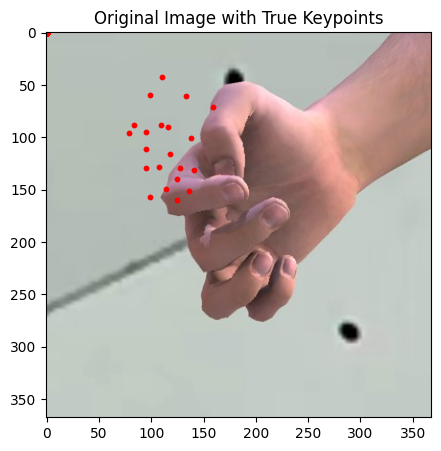

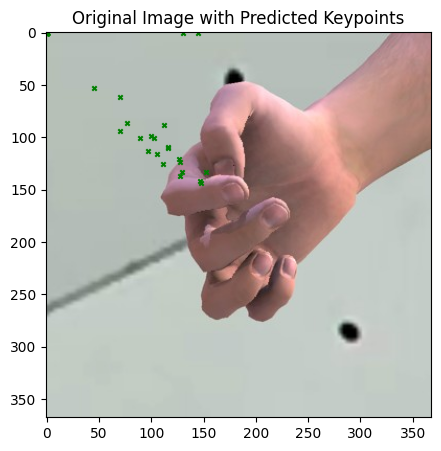

In [ ]:


# Выбираем случайный индекс из валидационного набора данных
random_idx = np.random.randint(len(val_loader.dataset))
image, keypoints, image_name = val_loader.dataset[random_idx]

# Перемещаем данные на устройство (GPU, если доступно)
image = image.to(device)
keypoints = keypoints.to(device)

# Получаем предсказание от модели
with torch.no_grad():
    model.eval()
    predicted_keypoints = model(image.unsqueeze(0)).squeeze(0)

# Преобразуем предсказанные ключевые точки обратно в исходный масштаб
predicted_keypoints = predicted_keypoints.cpu().numpy()
predicted_keypoints = predicted_keypoints.reshape(-1, 2) * (image.shape[-1] / 224)

# Загружаем оригинальное изображение
original_image = Image.open(image_name).convert('RGB')

# Перемещаем keypoints на CPU
keypoints = keypoints.cpu().numpy()

# Создаем новый график для оригинального изображения
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.title('Original Image with True Keypoints')
plt.scatter(keypoints[::2], keypoints[1::2], c='r', marker='o', s=10)
plt.show()

# Создаем новый график для предсказанных ключевых точек
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.title('Original Image with Predicted Keypoints')
plt.scatter(predicted_keypoints[::2], predicted_keypoints[1::2], c='g', marker='x', s=10)
plt.show()



In [ ]:
pip install mediapipe


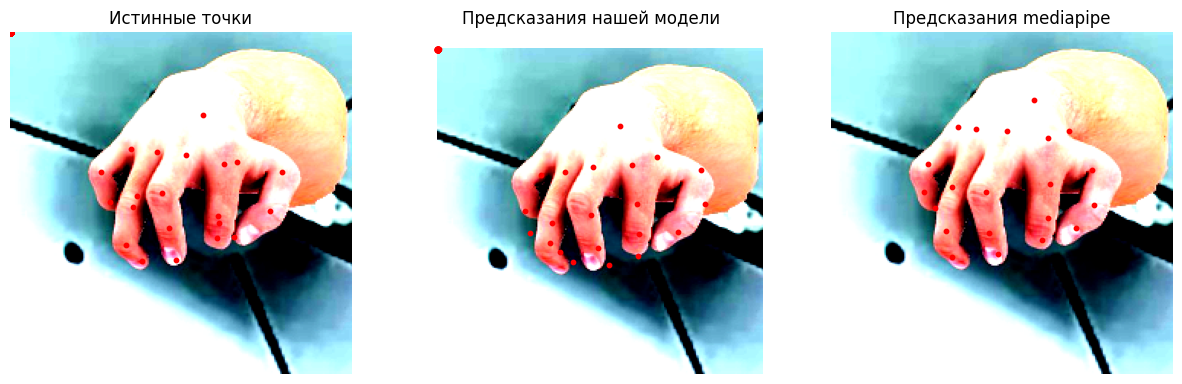

In [ ]:

# Создаем объект для работы с MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

# Выбираем случайное изображение из тестового набора данных
random_idx = np.random.randint(len(val_dataset))
image, target, image_path = val_dataset[random_idx]

# Трансформируем координаты для всех трех значений
target = target.detach().cpu().numpy()
target = np.array([target[i:i + 2] for i in range(0, len(target), 2)])
image = image.to(device)
pred = model.forward(image.unsqueeze(0))[0]
pred = pred.detach().cpu().numpy()
pred = np.array([pred[i:i + 2] for i in range(0, len(pred), 2)])


# Обрабатываем изображение с помощью MediaPipe Hands
image_cv2 = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
img_resize = cv2.resize(image_rgb, (224, 224), interpolation=cv2.INTER_AREA)

results = hands.process(img_resize)
results_xy = []
for hand_landmarks in results.multi_hand_landmarks:
    for landmark in hand_landmarks.landmark:
        results_xy.append(landmark.x)
        results_xy.append(landmark.y)

results_xy = [int(i * 224) for i in results_xy]
results_xy_c = np.array([results_xy[i:i + 2] for i in range(0, len(results_xy), 2)])

# Отображение результатов
img = image.cpu().numpy().transpose((1, 2, 0))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Первая картинка
axs[0].imshow(img)
axs[0].scatter(target[:, 0], target[:, 1], color='red', s=10)
axs[0].axis('off')
axs[0].set_title('Истинные точки')

# Вторая картинка
axs[1].imshow(img)
axs[1].scatter(pred[:, 0], pred[:, 1], color='red', s=10)
axs[1].axis('off')
axs[1].set_title('Предсказания нашей модели')

# Третья картинка
axs[2].imshow(img)
axs[2].scatter(results_xy_c[:, 0], results_xy_c[:, 1], color='red', s=10)
axs[2].axis('off')
axs[2].set_title('Предсказания mediapipe')

plt.show()
